# Eco-efficient Delivery 

Montmartre is known to be large hill in Paris where there are some streets with more than 120 metres elevation above sea level. Passing through up hills may be the shortest path between the depot pick-up location and the customer’s drop-off location but is not necessarily the fastest or the most eco-efficient route.

Authors: Mohamed Donia and Samar AbdelFattah
Supervisor: Dr. Alaa Khamis

In [1]:
import osmnx as ox
import networkx as nx
import time 
from ipyleaflet import Map
import numpy as np
from math import *
import math
import matplotlib.pyplot as plt
import json
import requests
import pandas as pd
from pandas import json_normalize
import folium 
from folium.plugins import HeatMap

## Case 1:

### Map With OSM:

In [2]:
# Create a graph for Montmartre region in Paris
location_point = (48.885496458, 2.337998648)
G = ox.graph_from_point(location_point,
                        dist=1000,
                        clean_periphery=True,
                        simplify=True,
                        network_type = "drive"
                       )

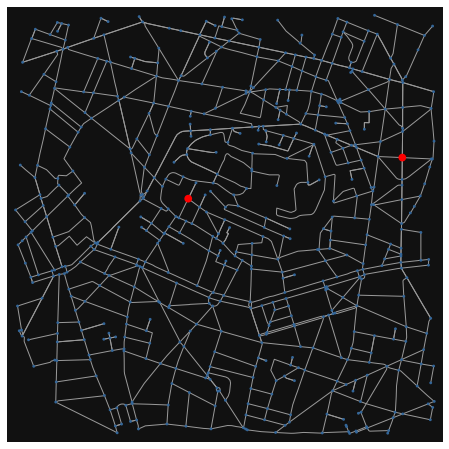

In [6]:
highlighted = [94239462,94225980]
# marking both the source and destination node
nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [60 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)
ox.speed.add_edge_speeds(G, hwy_speeds=None, fallback=None, precision=1)
ox.speed.add_edge_travel_times(G, precision=1)

### Obtaining Node height

In [7]:
website = r'https://api.opentopodata.org/v1/'
dataset = 'eudem25m?'
# dictionary to save node numbr and height 
elevation = {}    
# place to save location data to pass it to the wesite 
locations = ""
# place to save node index for sake of elevation dictionary
nodes_index = []
i = 0 
# get last element in itertor 
for last in G.nodes:
    pass
# loop to get elevation 
for n in G.nodes:
    locations = locations + str(G.nodes[n]['y']) + ',' + str(G.nodes[n]['x']) + '|'
    nodes_index.append(n)
    i += 1
    if i % 100 == 0  or n == last :
        url = website + dataset + 'locations=' + locations[:-1]
        r = requests.get(url)
        for segment,k in zip(r.json()['results'], range(len(r.json()['results']))):
            elevation[nodes_index[k]] = segment['elevation']
        locations = ""
        i = 0 
        nodes_index = []

### Plot Height Contours

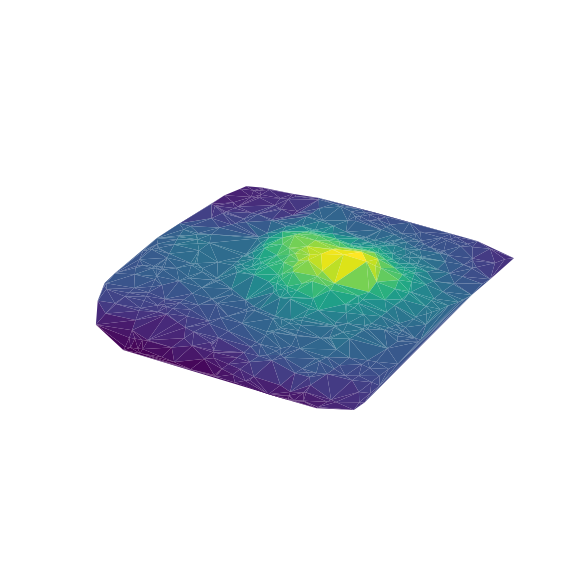

In [10]:
x = []
y = []
z = []
for node in G.nodes:
    x.append(G.nodes[node]['x'])
    y.append(G.nodes[node]['y'])
    z.append(elevation[node])

#ax = plt.axes(projection='3d')    
#ax.scatter(x, y, z)
#plt.show()
x = np.array(x)
y = np.array(y)
x = (x - np.min(x)) * 111000     #111000
y = (y - np.min(y)) * 180000
ax = plt.figure(figsize=(6, 6), dpi=120).add_subplot(projection='3d')
ax.plot_trisurf(x, y, z, linewidth=0.3, antialiased=True, cmap=plt.cm.viridis)
ax.set_box_aspect((np.max(x), np.max(y), np.max(z)*2.5))
plt.axis('off')
#ax.view_init(elev=50, azim=20)
plt.show()


In [11]:
from IPython.core.display import display, HTML
import json
import numpy as np

def plot3D(X, Y, Z, height=600, xlabel = "X", ylabel = "Y", zlabel = "Z", initialCamera = None):

    options = {
        "width": "100%",
        "style": "surface",
        "showPerspective": True,
        "showGrid": True,
        "showShadow": False,
        "keepAspectRatio": True,
        "height": str(height) + "px"
    }

    if initialCamera:
        options["cameraPosition"] = initialCamera
        
    data = [ {"x": X[y,x], "y": Y[y,x], "z": Z[y,x]} for y in range(X.shape[0]) for x in range(X.shape[1]) ]
    #data = [ {"x": X[i], "y": Y[i], "z": Z[i]} for i in range(X.shape[0]) ]
    visCode = r"""
       <link href="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.css" type="text/css" rel="stylesheet" />
       <script src="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.js"></script>
       <div id="pos" style="top:0px;left:0px;position:absolute;"></div>
       <div id="visualization"></div>
       <script type="text/javascript">
        var data = new vis.DataSet();
        data.add(""" + json.dumps(data) + """);
        var options = """ + json.dumps(options) + """;
        var container = document.getElementById("visualization");
        var graph3d = new vis.Graph3d(container, data, options);
        graph3d.on("cameraPositionChange", function(evt)
        {
            elem = document.getElementById("pos");
            elem.innerHTML = "H: " + evt.horizontal + "<br>V: " + evt.vertical + "<br>D: " + evt.distance;
        });
       </script>
    """
    htmlCode = "<iframe srcdoc='"+visCode+"' width='100%' height='" + str(height) + "px' style='border:0;' scrolling='no'> </iframe>"
    display(HTML(htmlCode))

In [12]:
X, Y = np.meshgrid(np.linspace(-3,3,50),np.linspace(-3,3,50))
Z = np.sin(X**2 + Y**2)**2/(X**2+Y**2)
plot3D(X,Y,Z)

/home/yinan/book-env/lib/python3.8/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Co2 Emissions Estimator:

#### Second by Second Model

In practice, it is usually difficult to know all the variables, such as 𝜂, $𝑝_{𝑖𝑑𝑙𝑒}$, μ, etc. To simplify the fuel consumption model and make it applicable to the eco-routing problem, we only keep the easy-to-measure variables, i.e., $𝑣_𝑡$ , $𝑎_𝑡$ , M, and 𝜃 in the model. Additionally, the difficult-to-measure variables will be substituted by parameters to be estimated. Hence, the fuel rate can be represented as follows:

$f_t=\beta_1 Mgcos(\theta)v_t+ \beta_2Mgsin(\theta)v_t+ \beta_3v_t^3+ \beta_4Ma_tv_t+\beta_5a_tv_t+\beta_6a_t+\beta_7$

**where :**

| Coeff | Value |
| --- | --- |
| $\beta_1$ | 0.0181 |
| $\beta_2$ | 0.0409 |
| $\beta_3$ | 0.0000232 |
| $\beta_4$ | 0.0779 |
| $\beta_5$ | 0.0131 |
| $\beta_6$ | 0.342 |
| $\beta_7$ | 0.101 |

**What we need :**
* car mass M in kg
* gravitational acceleration g
* $\theta$, $v_{t}$, $a_{t}$ is function in the road




In [13]:
def estimate_co2_model1(theta=0, v=15, a=0):
    '''
        theta in radian
        v m/s
        a m/s^2
        fuel rate (ml/s)
    ''' 
    # car parameters:
    mass = 1.555
    g = 9.81
    beta=[0, 0.0181,0.0409,0.0000232,0.0779,0.0131,0.342,0.101]
    ft = beta[1] * mass * g * cos(theta) * v + beta[2] * mass * g * sin(theta) * v +\
         beta[3] * v ** 3 + beta[4] * mass * a * v +\
         beta[5] * a * v + beta[6] * a + beta[7]
    return ft

#### Link-Level Model

Using multivariate regression analysis, where independent variables included link average traffic speed and road grade. Referring to their method, the link-level estimates can be aggregated based on instantaneous statistics as follows:

$ln(f_{link})=\alpha_0+\alpha_1v_l+\alpha_2v_l^2+\alpha_3v_l^3+\alpha_4v_l^4+\alpha_5g_l$

Where :
* $𝑣_𝑙$  : link average traffic speed (in miles per hour)
* $𝑔_𝑙$ : road grade in percentage of road length

| Coeff | Value |
| --- | --- |
| $\alpha_0$ | 6.8 |
| $\alpha_1$ | -0.14 |
| $\alpha_2$ | 0.0392 |
| $\alpha_3$ | -5.2e-5 |
| $\alpha_4$ | 2.57e-7 |
| $\alpha_5$ | 0.137 |

In [14]:
def Estimate_Co2_Model2(gl=0, v=15, length= 0):
    '''
    format of received paremeters :
        gl -----------> (in percentage)
        length -------> m
        v ------------> m/s
        
    '''
    
    length /= 1609.344
    v *= 2.23693629
    '''
    model parameters : 
        length -------> miles
        v ------------> (in miles per hour)
        fuel ---------> grams per mile
    ''' 
    
    # car parameters:
    alpha=[6.8, -0.14, 0.00392, -0.000052, 0.000000257, 0.137]
    # fuel consumption gram per mile :
    ft = exp(alpha[0] + alpha[1] * v + alpha[2] * v**2 + alpha[3] * v**3 + alpha[4] * v**4 + alpha[5] * gl)
    # fuel consumption gram :
    fuel = ft * length
    return fuel

### Distance, Time, Fuel Cost Functions: 

In [15]:
# this function to get fuel consumption for specified path
def get_distance_cost(G, route):
    route = list(route)
    weight = 0
    for u,v in zip(route[:-1], route[1:]):
        leng = G[u][v][0]['length']
        weight += leng
    return weight
def get_time_cost(G, route):
    route = list(route)
    weight = 0
    for u,v in zip(route[:-1], route[1:]):
        leng = G[u][v][0]['travel_time']
        weight += leng
    return weight
def get_fuel_cost(G, route):
    route = list(route)
    weight = 0
    for u,v in zip(route[:-1], route[1:]):
        point1_h = elevation[u]
        point2_h = elevation[v]
        leng = G[u][v][0]['length']
        grad = np.max([(point2_h -point1_h) / leng * 100, 0])
        speed = G[u][v][0]['speed_kph'] * 0.277777778 * 3
        fuel = Estimate_Co2_Model2(grad, speed, leng)
        weight += fuel
    return weight
        

#### Fuel Consumption Vs. Speed For Link Level Model

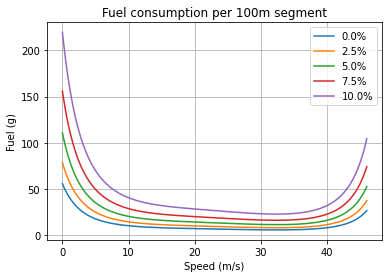

In [16]:
length = 100   # meter
speeds = np.linspace(0, 46, 200)  # m/s
angles = np.linspace(0, 10, 5) # percentage
for angle in angles:
    fuel = []
    for speed in speeds:
        f = Estimate_Co2_Model2(angle, speed, length)
        fuel.append(f)
    plt.plot(speeds, fuel, label=str(angle)+"%")
    
plt.grid()
plt.xlabel("Speed (m/s)")
plt.ylabel("Fuel (g)")
plt.title("Fuel consumption per 100m segment")
plt.legend()
plt.show()

### Dijkstra Algorithm Implementation:

In [17]:
'''
    This function is refine of the Dijsktra algorithm. 
    Here, we will terminate the searching after reaching the destination.
'''
def Dijkstra_fine(G,origin,destination, criteria = 'Distance'):
    # convert map nodes into index from 0 to length(nodes) to simplify our algorithm 
    n = len(G.nodes)
    map_nodes = list(G.nodes)
    # initial defination of the distance list with infinity for all nodes and zero for source node
    dist = [math.inf] * n
    dist[map_nodes.index(origin)] = 0
    # mark all nodes as unvisited 
    visited = [False] * n
    parent  = [None] * n
    while sum(visited) <= n:
        # index of the node of the minimum dist with condition that it is not visited
        current_node = dist.index(min(dist[at] for at in range(len(dist)) if visited[at]==False))
        # here, we will  terminate the searching after reaching the the required destination 
        if current_node == map_nodes.index(destination) :
            break
        # iterate over all neighbors of the current node
        for child in nx.neighbors(G,map_nodes[current_node]):
            # get distance between currrent node and child node
            distance = dist[current_node] + func(G,map_nodes[current_node],child, criteria)
            # update minimum distance if the calculated distnace is less than previous distance
            if distance < dist[map_nodes.index(child)]:
                dist[map_nodes.index(child)] = distance
                parent[map_nodes.index(child)] = current_node
        visited[current_node] = True
        #print(str(sum(visited)/len(visited)*100)+'--'+str(current_node))

    # here we can define our path back from the destination   
    path = []            
    path.append(map_nodes.index(destination))
    while path[-1] != None:
        path.append(parent[path[-1]])
    path.pop()
    path.reverse()
    return [map_nodes[i] for i in path]

'''
    this function represent the cost function we will define 
'''
# here we can put our required cost function :
def func(G, node1, node2, criteria):
    if criteria =='Distance':
        distance = G[node1][node2][0]['length'] # length between the nodes
    elif criteria == 'Time':
        distance = G[node1][node2][0]['travel_time'] # time between the nodes
    return distance


In [18]:
class Node:
    # using __slots__ for optimization
    __slots__ = ['node', 'distance', 'parent', 'osmid', 'G']
    # constructor for each node
    def __init__(self ,graph , osmid, distance = 0, parent = None):
        # the dictionary of each node as in networkx graph --- still needed for internal usage
        self.node = graph[osmid]
        # the distance from the parent node --- edge length
        self.distance = distance
        # the parent node
        self.parent = parent
        # unique identifier for each node so we don't use the dictionary returned from osmnx
        self.osmid = osmid
        # the graph
        self.G = graph
    # returning all the nodes adjacent to the node
    #def expand(self):
    #     children = [Node(graph = self.G, osmid = child, distance = self.node[child][0]['length'], parent = self) \
    #                    for child in self.node]
    def expand(self, criteria):
        children = []
        for child in self.node:
            if criteria == 'Time':
                dist = self.node[child][0]['travel_time']
            elif criteria == 'Distance':
                dist = self.node[child][0]['length']
            elif criteria == 'Fuel':
                point1_h = elevation[self.osmid]
                point2_h = elevation[child]
                leng = self.node[child][0]['length']
                grad = np.max([(point2_h -point1_h) / leng * 100, 0])
                speed = self.node[child][0]['speed_kph'] * 0.277777778 * 3
                dist = Estimate_Co2_Model2(grad, speed, leng)
        
            Node_ = Node(graph = self.G, 
                         osmid = child,
                         distance = dist,
                         parent = self)
            children.append(Node_)
        return children 
    # returns the path from that node to the origin as a list and the length of that path
    def path(self):
        node = self
        path = []
        while node:
            path.append(node.osmid)
            node = node.parent
        return path[::-1]
    # the following two methods are for dictating how comparison works
    def __eq__(self, other):
        try:
            return self.osmid == other.osmid
        except:
            return self.osmid == other
    def __hash__(self):
        return hash(self.osmid)

In [22]:
def Dijkstra(G,origin,destination,criteria = 'Distance'):
    seen = set()         # for dealing with self loops
    shortest_dist = {osmid: math.inf for osmid in G.nodes()}
    unrelaxed_nodes = [Node(graph = G, osmid = osmid) for osmid in G.nodes()]

    shortest_dist[origin.osmid] = 0
    found = False

    while len(unrelaxed_nodes) > 0 and not found:
        node = min(unrelaxed_nodes, key = lambda node : shortest_dist[node.osmid])  
        # relaxing the node, so this node's value in shortest_dist
        # is the shortest distance between the origin and destination
        unrelaxed_nodes.remove(node)
        seen.add(node.osmid)  
        # if the destination node has been relaxed
        # then that is the route we want
        if node == destination:
            route = node.path()
            cost = shortest_dist[node.osmid]
            found = True
            continue
        # otherwise, let's relax edges of its neighbours
        for child in node.expand(criteria):
            # skip self-loops
            if child.osmid in seen: continue
            # this doesn't look pretty because Node is just an object
            # so retrieving it is a bit verbose -- if you have nicer 
            # way to do that, please open an issue
            child_obj = next((node for node in unrelaxed_nodes if node.osmid == child.osmid), None)
            child_obj.distance = child.distance
            distance = shortest_dist[node.osmid] + child.distance
            if distance < shortest_dist[child_obj.osmid]:
                shortest_dist[child_obj.osmid] = distance
                child_obj.parent = node
    return route

### Get Path With Minimum Distance

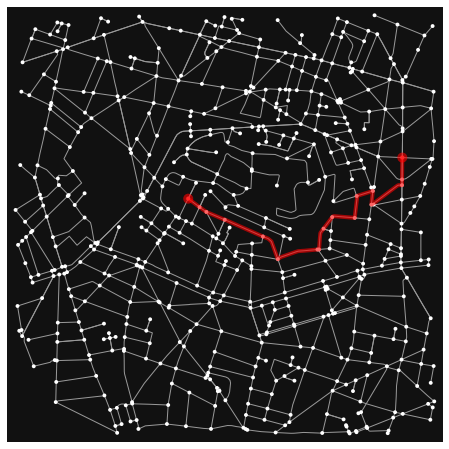

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [23]:
origin =  highlighted[0]
destination = highlighted[1]
route1 = Dijkstra_fine(G,origin,destination, 'Distance')
#route2 = Dijkstra_fine(G,origin,destination, 'Time')
ox.plot_graph_route(G, route1, route_color='r', route_linewidth=4, route_alpha=0.6)

### Routes With Minimum Distance, Time and Fuel Criteria

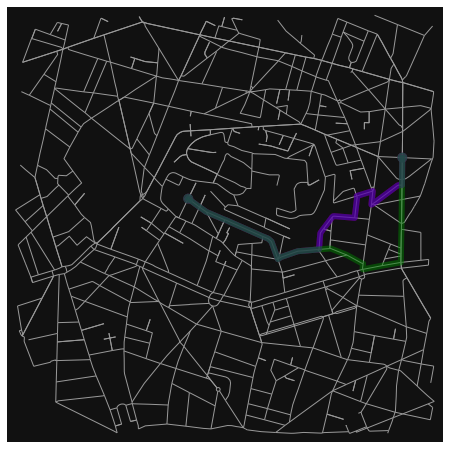

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [24]:
# first define the origin/source nodes as Node
origin = Node(graph = G, osmid = highlighted[0])
destination = Node(graph = G, osmid = highlighted[1])
route1 = Dijkstra(G,origin,destination, 'Distance')
route2 = Dijkstra(G,origin,destination, 'Time')
route3 = Dijkstra(G,origin,destination, 'Fuel')
ox.plot_graph_routes(G, 
                     [route1, route2, route3], 
                     route_colors=['r', 'b', 'g'], 
                     route_linewidths=6, 
                     node_size=0)

In [25]:
print("For route with minimum distance : ")
print("Distance cost : ", get_distance_cost(G, route1), ' m')
print("Time cost :", get_time_cost(G, route1), 'sec')
print("Fuel cost :", get_fuel_cost(G, route1), 'gram')
# ------------------------------------- #
print("")
print("For route with minimum time : ")
print("Distance cost : ", get_distance_cost(G, route2), ' m')
print("Time cost :", get_time_cost(G, route2), 'sec')
print("Fuel cost :", get_fuel_cost(G, route2), 'gram')
# -------------------------------------- #
print("")
print("For route with minimum fuel : ")
print("Distance cost : ", get_distance_cost(G, route3), ' m')
print("Time cost :", get_time_cost(G, route3), 'sec')
print("Fuel cost :", get_fuel_cost(G, route3), 'gram')

For route with minimum distance : 
Distance cost :  1586.041  m
Time cost : 190.3 sec
Fuel cost : 170.7603089788183 gram

For route with minimum time : 
Distance cost :  1586.041  m
Time cost : 190.3 sec
Fuel cost : 170.7603089788183 gram

For route with minimum fuel : 
Distance cost :  1683.2079999999999  m
Time cost : 202.2 sec
Fuel cost : 163.49392351947304 gram


### Show Routes on Folium Map: 

In [26]:
# generate a new map
folium_map = folium.Map(location=location_point,
                        zoom_start=15,
                        tiles="OpenStreetMap")
paths = [route1, route2, route3]
color_list = ['#FF3333', '#0F3FE5', '#55DF15']
for path,color in zip(paths,color_list):
    path_coordinates = []
    for i in path:
        path_coordinates.append([G.nodes[i]['y'],G.nodes[i]['x']])
    line = folium.PolyLine(path_coordinates,
                           weight=4,
                           color=color
                          ).add_to(folium_map)
    
folium_map

## Case 2:

In [2]:
location_point = (48.885496458, 2.337998648)
G = ox.graph_from_point(location_point,
                        dist=3000,
                        clean_periphery=True,
                        simplify=True,
                        network_type = "drive"
                       )

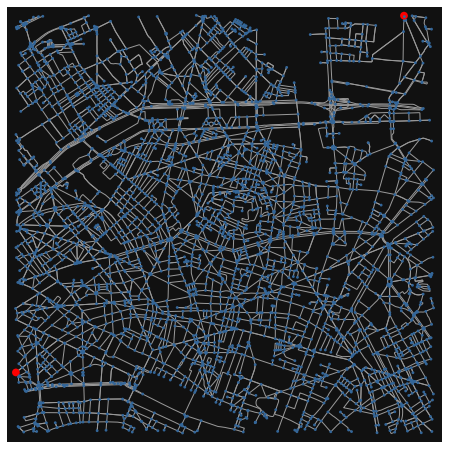

In [3]:
highlighted = [1430111689,25625242]
# marking both the source and destination node
nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [60 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)
# add edge speeds :
ox.speed.add_edge_speeds(G, hwy_speeds=None, fallback=None, precision=1)
# add edge travel times :
ox.speed.add_edge_travel_times(G, precision=1)
# add edge bearings :
ox.bearing.add_edge_bearings(G, precision=1)
# add elevation from raster file
# the raster file of the area of interest is obtained from https://srtm.csi.cgiar.org/srtmdata/
ox.elevation.add_node_elevations_raster(G, "srtm_37_03.tif", band=1, cpus=None) 
# add edge grades :
ox.elevation.add_edge_grades(G, add_absolute=True, precision=3)

### Link-Level Model

In [4]:
def Estimate_Co2_Model2(gl=0, v=15, length= 0):
    '''
    format of received paremeters :
        gl -----------> (in percentage)
        length -------> m
        v ------------> m/s
        
    '''
    
    length /= 1609.344
    v *= 2.23693629
    '''
    model parameters : 
        length -------> miles
        v ------------> (in miles per hour)
        fuel ---------> grams per mile
    ''' 
    
    # car parameters:
    alpha=[6.8, -0.14, 0.00392, -0.000052, 0.000000257, 0.137 * 1.5]
    # fuel consumption gram per mile :
    ft = exp(alpha[0] + alpha[1] * v + alpha[2] * v**2 + alpha[3] * v**3 + alpha[4] * v**4 + alpha[5] * gl)
    # fuel consumption gram :
    fuel = ft * length
    return fuel

### Distance, Time, Fuel Cost Functions: 

In [5]:
# this function to get fuel consumption for specified path
def get_distance_cost(G, route):
    route = list(route)
    weight = 0
    for u,v in zip(route[:-1], route[1:]):
        leng = G[u][v][0]['length']
        weight += leng
    return weight
def get_time_cost(G, route):
    route = list(route)
    weight = 0
    for u,v in zip(route[:-1], route[1:]):
        leng = G[u][v][0]['travel_time']
        weight += leng
    return weight
def get_fuel_cost(G, route):
    route = list(route)
    weight = 0
    for u,v in zip(route[:-1], route[1:]):
        '''
        point1_h = elevation[u]
        point2_h = elevation[v]
        leng = G[u][v][0]['length']
        grad = np.max([(point2_h -point1_h) / leng * 100, 0])
        speed = G[u][v][0]['speed_kph'] * 0.277777778 * 2
        '''
        leng = G[u][v][0]['length']
        speed = G[u][v][0]['speed_kph'] * 0.277777778 * 2
        grad = np.max([G[u][v][0]['grade'] * 100 , 0])
        fuel = Estimate_Co2_Model2(grad, speed, leng)
        weight += fuel
    return weight
def get_turns(G, route):
    edge_bearings = []
    route = list(route)
    for u,v in zip(route[:-1], route[1:]):
        edge_bearings.append(G[u][v][0]['bearing'])
    # get the difference :
    right_turns = 0
    left_turns = 0
    for u_bearing,v_bearing in zip(edge_bearings[1:], edge_bearings[:-1]):
        diff = u_bearing - v_bearing
        if diff > 60:
            right_turns +=1
        elif diff < -60:
            left_turns +=1
    return right_turns, left_turns

### Dijkstra Algorithm Implementation:

In [6]:
class Node:
    # using __slots__ for optimization
    __slots__ = ['node', 'distance', 'parent', 'osmid', 'G']
    # constructor for each node
    def __init__(self ,graph , osmid, distance = 0, parent = None):
        # the dictionary of each node as in networkx graph --- still needed for internal usage
        self.node = graph[osmid]
        # the distance from the parent node --- edge length
        self.distance = distance
        # the parent node
        self.parent = parent
        # unique identifier for each node so we don't use the dictionary returned from osmnx
        self.osmid = osmid
        # the graph
        self.G = graph
    # returning all the nodes adjacent to the node
    #def expand(self):
    #     children = [Node(graph = self.G, osmid = child, distance = self.node[child][0]['length'], parent = self) \
    #                    for child in self.node]
    def expand(self, criteria):
        children = []
        for child in self.node:
            if criteria == 'Time':
                dist = self.node[child][0]['travel_time']
            elif criteria == 'Distance':
                dist = self.node[child][0]['length']
            elif criteria == 'Fuel':
                '''
                point1_h = elevation[self.osmid]
                point2_h = elevation[child]
                leng = self.node[child][0]['length']
                grad = np.max([(point2_h -point1_h) / leng * 100, 0])
                speed = self.node[child][0]['speed_kph'] * 0.277777778 * 2
                dist = Estimate_Co2_Model2(grad, speed, leng)
                '''
                leng = self.node[child][0]['length']
                speed = self.node[child][0]['speed_kph'] * 0.277777778 * 2
                grad = np.max([self.node[child][0]['grade'] * 100 , 0])
                dist = Estimate_Co2_Model2(grad, speed, leng)
        
            Node_ = Node(graph = self.G, 
                         osmid = child,
                         distance = dist,
                         parent = self)
            children.append(Node_)
        return children 
    # returns the path from that node to the origin as a list and the length of that path
    def path(self):
        node = self
        path = []
        while node:
            path.append(node.osmid)
            node = node.parent
        return path[::-1]
    # the following two methods are for dictating how comparison works
    def __eq__(self, other):
        try:
            return self.osmid == other.osmid
        except:
            return self.osmid == other
    def __hash__(self):
        return hash(self.osmid)

In [7]:
def Dijkstra(G,origin,destination,criteria = 'Distance'):
    seen = set()         # for dealing with self loops
    shortest_dist = {osmid: math.inf for osmid in G.nodes()}
    unrelaxed_nodes = [Node(graph = G, osmid = osmid) for osmid in G.nodes()]

    shortest_dist[origin.osmid] = 0
    found = False

    while len(unrelaxed_nodes) > 0 and not found:
        node = min(unrelaxed_nodes, key = lambda node : shortest_dist[node.osmid])  
        # relaxing the node, so this node's value in shortest_dist
        # is the shortest distance between the origin and destination
        unrelaxed_nodes.remove(node)
        seen.add(node.osmid)  
        # if the destination node has been relaxed
        # then that is the route we want
        if node == destination:
            route = node.path()
            cost = shortest_dist[node.osmid]
            found = True
            continue
        # otherwise, let's relax edges of its neighbours
        for child in node.expand(criteria):
            # skip self-loops
            if child.osmid in seen: continue
            # this doesn't look pretty because Node is just an object
            # so retrieving it is a bit verbose -- if you have nicer 
            # way to do that, please open an issue
            child_obj = next((node for node in unrelaxed_nodes if node.osmid == child.osmid), None)
            child_obj.distance = child.distance
            distance = shortest_dist[node.osmid] + child.distance
            if distance < shortest_dist[child_obj.osmid]:
                shortest_dist[child_obj.osmid] = distance
                child_obj.parent = node
    return route

### Routes With Minimum Distance, Time and Fuel Criteria

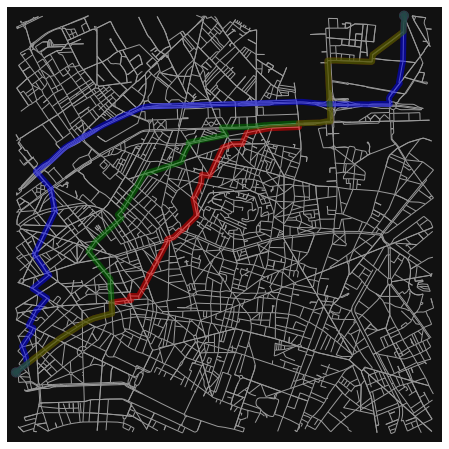

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [8]:
# first define the origin/source nodes as Node
origin = Node(graph = G, osmid = highlighted[0])
destination = Node(graph = G, osmid = highlighted[1])
route1 = Dijkstra(G,origin,destination, 'Distance')
route2 = Dijkstra(G,origin,destination, 'Time')
route3 = Dijkstra(G,origin,destination, 'Fuel')
ox.plot_graph_routes(G, 
                     [route1, route2, route3], 
                     route_colors=['r', 'b', 'g'], 
                     route_linewidths=6, 
                     node_size=0)

In [9]:
print("For route with minimum distance : ")
dist_route1 = round(get_distance_cost(G, route1))
time_route1 = round(get_time_cost(G, route1))
fuel_route1 = round(get_fuel_cost(G, route1))
print("Distance cost : ", dist_route1, ' m')
print("Time cost :", time_route1, 'sec')
print("Fuel cost :", fuel_route1, 'gram')
# ------------------------------------- #
print("")
print("For route with minimum time : ")
dist_route2 = round(get_distance_cost(G, route2))
time_route2 = round(get_time_cost(G, route2))
fuel_route2 = round(get_fuel_cost(G, route2))
print("Distance cost : ", dist_route2, ' m')
print("Time cost :", time_route2, 'sec')
print("Fuel cost :", fuel_route2, 'gram')
# -------------------------------------- #
print("")
print("For route with minimum fuel : ")
dist_route3 = round(get_distance_cost(G, route3))
time_route3 = round(get_time_cost(G, route3))
fuel_route3 = round(get_fuel_cost(G, route3))
print("Distance cost : ", dist_route3, ' m')
print("Time cost :", time_route3, 'sec')
print("Fuel cost :", fuel_route3, 'gram')
# --------------------------------------- #
right_turns_route1, left_turns_route1 = get_turns(G, route1)
right_turns_route2, left_turns_route2 = get_turns(G, route2)
right_turns_route3, left_turns_route3 = get_turns(G, route3)

For route with minimum distance : 
Distance cost :  9041  m
Time cost : 1033 sec
Fuel cost : 936105 gram

For route with minimum time : 
Distance cost :  10294  m
Time cost : 849 sec
Fuel cost : 20280 gram

For route with minimum fuel : 
Distance cost :  9580  m
Time cost : 1021 sec
Fuel cost : 858 gram


### Show Routes on Folium Map: 

In [10]:
x = []
y = []
z = []
for node in G.nodes:
    x.append(G.nodes[node]['x'])
    y.append(G.nodes[node]['y'])
    z.append(G.nodes[node]['elevation'])
x = np.array(x)
y = np.array(y)
z = np.array(z)
data=np.array([y,x,z]).T

In [29]:
# generate a new map
folium_map = folium.Map(location=location_point,
                        zoom_start=13,
                        tiles="OpenStreetMap")
paths = [route1, route2, route3]
color_list = ['#FF3333', '#0F3FE5', '#55DF15']    # red, blue, green
for path,color in zip(paths,color_list):
    path_coordinates = []
    for i in path:
        path_coordinates.append([G.nodes[i]['y'],G.nodes[i]['x']])
    line = folium.PolyLine(path_coordinates,
                           weight=4,
                           color=color
                          ).add_to(folium_map)
# add folium marker
folium.Marker(location=[G.nodes[highlighted[0]]['y'],
                        G.nodes[highlighted[0]]['x']],
              icon= folium.Icon(color='blue',icon='map-marker'),
              popup = 'Origin').add_to(folium_map)

folium.Marker(location=[G.nodes[highlighted[1]]['y'],
                        G.nodes[highlighted[1]]['x']],
              icon= folium.Icon(color='red',icon='map-marker'),
              popup = 'Destination').add_to(folium_map)


HeatMap(data, radius=15, opacity = 1).add_to(folium.FeatureGroup(name='Heat Map').add_to(folium_map))
folium.LayerControl().add_to(folium_map)
# show the map layers:
folium_map

In [11]:
df = pd.DataFrame([[dist_route1, time_route1, fuel_route1, right_turns_route1, left_turns_route1],
                   [dist_route2, time_route2, fuel_route2, right_turns_route2, left_turns_route2],
                   [dist_route3, time_route3, fuel_route3, right_turns_route3, left_turns_route3]],
                  index=pd.Index(['Min Dist Criteria','Min Time Criteria', 'Min Fuel Criteria']),
                  columns=pd.Index(['Distance (metre)','Time (sec)','Fuel (gram)', 'Right turns', 'Left turns']))

df.style.highlight_min(color = 'lightgreen', 
                       axis = 0)

,Distance (metre),Time (sec),Fuel (gram),Right turns,Left turns
Min Dist Criteria,9041,1033,936105,7,7
Min Time Criteria,10294,849,20280,5,3
Min Fuel Criteria,9580,1021,858,3,4
